In [4]:
import os
import torch
import zipfile
import requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from dgl import DGLGraph

Declaring some Constants to use after

In [33]:
dataset = 'mutag'
out_folder = "C:/Users/Rez/Desktop/NNDS_PROJECT"

ADJACENCY_SUFFIX = '_A.txt'
GRAPH_ID_SUFFIX = '_graph_indicator.txt'
GRAPH_LABELS_SUFFIX = '_graph_labels.txt'
NODE_LABELS_SUFFIX = '_node_labels.txt'
EDGE_LABELS_SUFFIX = '_edge_labels.txt'

GRAPH = 'graph'
LABELS = 'labels'
N_RELS = 'n_relations'
N_CLASSES = 'n_classes'
N_ENTITIES = 'n_entities'

GNN_EDGE_NORM = 'norm'
GNN_NODE_LABELS_KEY = 'hnl'
GNN_EDGE_LABELS_KEY = 'hel'

SUFFIX = [
    ADJACENCY_SUFFIX,
    GRAPH_ID_SUFFIX,
    GRAPH_LABELS_SUFFIX,
    NODE_LABELS_SUFFIX,
    EDGE_LABELS_SUFFIX,
]

In [34]:
SUFFIX

['_A.txt',
 '_graph_indicator.txt',
 '_graph_labels.txt',
 '_node_labels.txt',
 '_edge_labels.txt']

#### The link to the datasets of the TU Dortmund University
downloading and saving to our path the "MUTAG" dataset from this link

In [35]:
dataset_url = 'https://ls11-www.cs.tu-dortmund.de/people/morris/graphkerneldatasets/MUTAG.zip'

In [36]:
def complete_path(folder, fname):
    return os.path.join(folder, fname)

In [37]:
DATASET_PATH = complete_path(out_folder, 'mutag.zip')

r = requests.get(dataset_url, allow_redirects=True)
r.raise_for_status()

In [38]:
r

<Response [200]>

#### Extracting the mutag.zip file

Mutag dataset consist of these files: <br/>
-MUTAG_A.txt<br/>
-MUTAG_edge_labels.txt <br/>
-MUTAG_graph_indicator.txt <br/>
-MUTAG_graph_labels.txt <br/>
-MUTAG_node_labels.txt <br/>
-README.txt <br/>

In [39]:
with open(DATASET_PATH, 'wb') as fhandle:
    fhandle.write(r.content)

EXTRACT_FOLDER = complete_path(out_folder, 'unzipped')
with zipfile.ZipFile(DATASET_PATH, "r") as zip_ref:
    zip_ref.extractall(EXTRACT_FOLDER)

In [40]:
d = os.listdir(EXTRACT_FOLDER)
# d = ['MuTAG']
dataset_name = d[0]
dirpath = complete_path(EXTRACT_FOLDER, dataset_name)
dirpath

'C:/Users/Rez/Desktop/NNDS_PROJECT\\unzipped\\MUTAG'

#### Making the a dictionary 
in this section I make a dictionary like this from all files except README.txt=> *name of the file : its data*

In [41]:
if len(d) != 1:
    raise RuntimeError
dataset_name = d[0]
dirpath = complete_path(EXTRACT_FOLDER, dataset_name)
data = dict()
for f in os.listdir(dirpath):
    if f == "README.txt":
        continue
    fpath = complete_path(dirpath, f)
    suffix = f.replace(dataset_name, '')
    data[suffix] = np.loadtxt(fpath, dtype=np.int, delimiter=',')

In [42]:
data

{'_A.txt': array([[   2,    1],
        [   1,    2],
        [   3,    2],
        ...,
        [3369, 3370],
        [3371, 3369],
        [3369, 3371]]),
 '_edge_labels.txt': array([0, 0, 0, ..., 2, 1, 1]),
 '_graph_indicator.txt': array([  1,   1,   1, ..., 188, 188, 188]),
 '_graph_labels.txt': array([ 1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,
         1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
         1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,
         1, -1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,
         1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,
         1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1,
        -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1,
         1, -1, -1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1,  1,
        -1, -1, 

#### Building the Graphs

In [43]:
# declaring some dict variables
graph_ids = set(data[GRAPH_ID_SUFFIX])
node2graph = dict()
graphs = dict()
graph_labels = dict()

node2node_per_graph = dict()

#### Build Graphs with Nodes

In [44]:
for g_id in graph_ids:
    #find the node_ids of each graph
    node_ids = np.argwhere(data[GRAPH_ID_SUFFIX] == g_id).squeeze()
    node_ids.sort()
    n2n = dict()
    
    # node2graph dictionary defines that each node belongs to which graph_id
    for idx, n_id in enumerate(node_ids):
        node2graph[n_id] = g_id
        n2n[n_id] = idx
    
    # declaring 'g' as a 'dgl' library graph
    g = DGLGraph()
    
    # adding nodes to our graph
    g.add_nodes(len(node_ids), {GNN_NODE_LABELS_KEY: torch.from_numpy(data[NODE_LABELS_SUFFIX][node_ids])})
    
    # graphs is a dictionary of graph_id as its key and DGLGraph as its value for each graph (total key = 188)
    graphs[g_id] = g
    # node2node_per_graph is a dictionary of all nodes that belongs to each graph (graph_id:{its node_ids : counter})
    node2node_per_graph[g_id] = n2n
    # graph_labels declare that what is label of each graph_id
    graph_labels[g_id] = data[GRAPH_LABELS_SUFFIX][g_id - 1]

#### Process Edges

In [45]:
for i in range(len(data[ADJACENCY_SUFFIX])):
    # reducing 1 from node_ids because in DGLGraph node numbers are start with 0
    # but our nodes in Mutag dataset are start with 1
    orig_edge = data[ADJACENCY_SUFFIX][i] - 1
    
    # Source nodes
    n_id_0 = orig_edge[0]
    
    #find its graph_id
    g_id = node2graph[n_id_0]
    
    n2n = node2node_per_graph[g_id]

    edata = {}

    if EDGE_LABELS_SUFFIX in data:
        edata[GNN_EDGE_LABELS_KEY] = torch.from_numpy(np.expand_dims(np.array(data[EDGE_LABELS_SUFFIX][i]), axis=0))
    
    # completing graphs dictionary with adding edges to it
    graphs[g_id].add_edge(n2n[n_id_0], n2n[orig_edge[1]], edata)

In [46]:
graph_list = []
labels = []

# making 2 lists of DGLGraphs and their labels
for g_id in graphs.keys():
    graph_list.append(graphs[g_id])
    labels.append(graph_labels[g_id])

#### Add Edge Normalization

In [47]:
for graph in graph_list:
    edge_src, edge_dst = graph.edges()
    edge_dst = list(edge_dst.data.numpy())
    edge_type = list(graph.edata[GNN_EDGE_LABELS_KEY])
    _, inverse_index, count = np.unique((edge_dst, edge_type), axis=1, return_inverse=True,
                                        return_counts=True)
    degrees = count[inverse_index]
    edge_norm = np.ones(len(edge_dst), dtype=np.float32) / degrees.astype(np.float32)
    graph.edata[GNN_EDGE_NORM] = torch.FloatTensor(edge_norm)

#### Pickle
The pickle module implements binary protocols for serializing and de-serializing a Python object structure.

In [48]:
import dill as pickle

# using these functions to saves our data 
def save_pickle(obj, ofpath):
    """
    Save an object as pickle

    Args:
        graph (DGLGraph): graph to be saved
        ofpath (str): path where to store the file
    """
    with open(ofpath, 'wb') as ofh:
        pickle.dump(obj, ofh)


def load_pickle(ifpath):
    """
    Load an object from pickle

    Args:
        ifpath (str): path from where a graph is loaded
    """
    with open(ifpath, 'rb') as ifh:
        return pickle.load(ifh)


def complete_path(folder, fname):
    return os.path.join(folder, fname)


#### Save Data 

In [49]:
label_set = set(labels)
num_labels = len(label_set)
mapping = dict(zip(label_set, list(range(num_labels))))
labels = [mapping[label] for label in labels]

num_entities = len(set(data[NODE_LABELS_SUFFIX]))
num_rels = len(set(data[EDGE_LABELS_SUFFIX]))

torch.save(torch.LongTensor(labels), complete_path(out_folder, LABELS))

save_pickle(graph_list, complete_path(out_folder, GRAPH))
save_pickle(num_labels, complete_path(out_folder, N_CLASSES))
save_pickle(num_entities, complete_path(out_folder, N_ENTITIES))
save_pickle(num_rels, complete_path(out_folder, N_RELS))

In [50]:
def main(folder):
    data = {
        GRAPH: load_pickle(complete_path(folder, GRAPH)),
        N_CLASSES: load_pickle(complete_path(folder,N_CLASSES)),
        N_ENTITIES: load_pickle(complete_path(folder, N_ENTITIES)),
        N_RELS: load_pickle(complete_path(folder, N_RELS))
    }

    for k in [LABELS]:
        data[k] = torch.load(complete_path(folder, k))

    return data

In [51]:
folder = "C:/Users/Rez/Desktop/NNDS_PROJECT"
data_graph = main(folder)

#### Drawing graphs

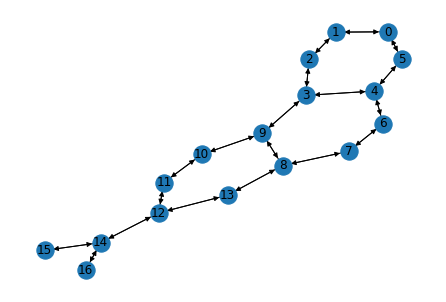

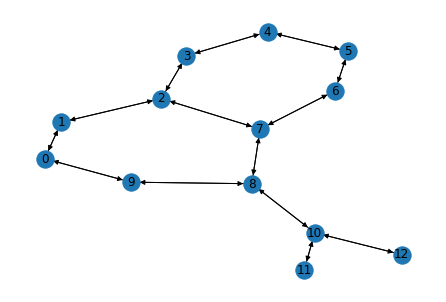

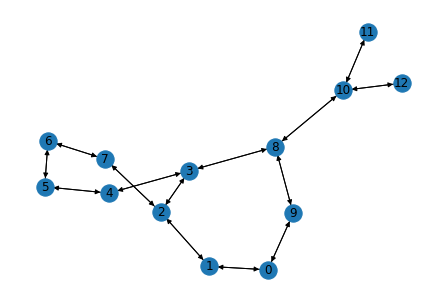

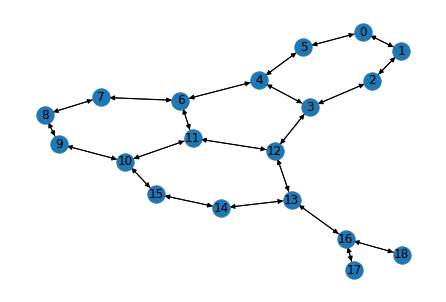

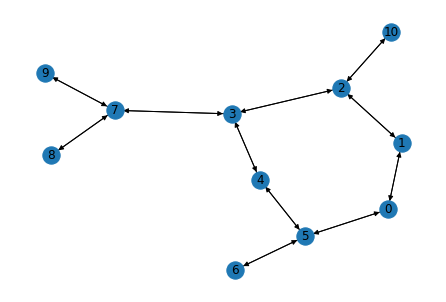

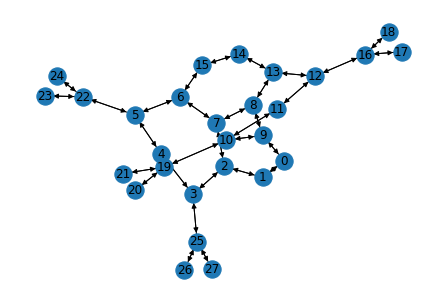

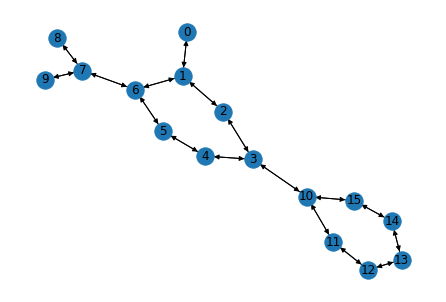

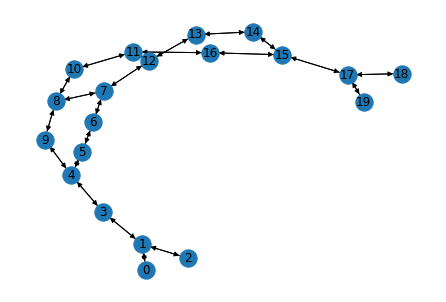

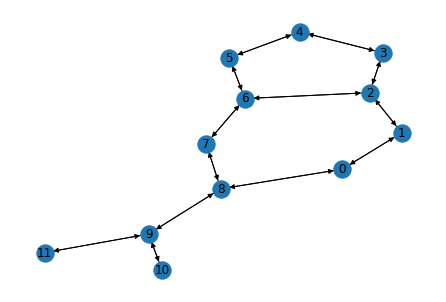

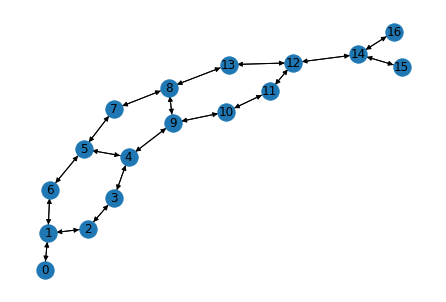

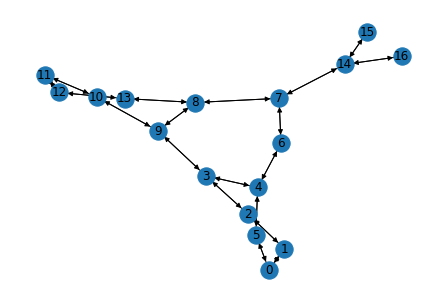

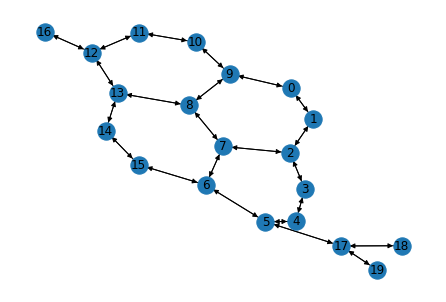

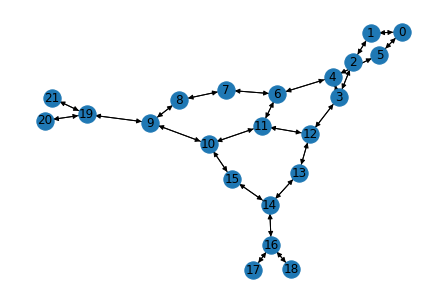

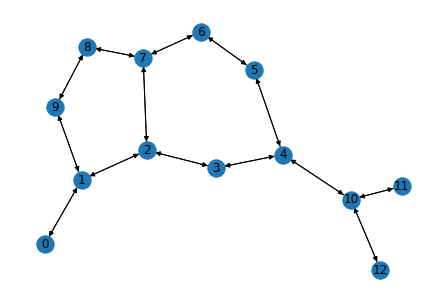

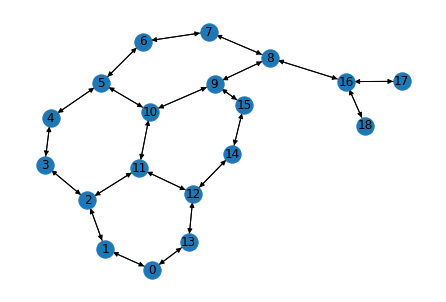

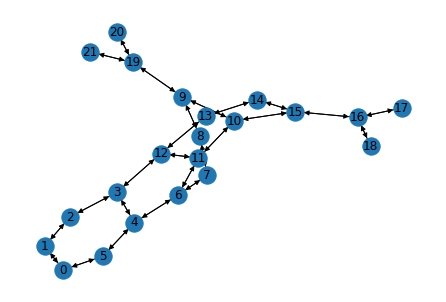

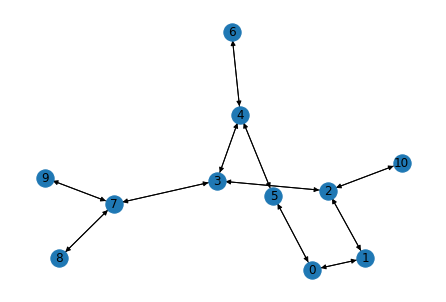

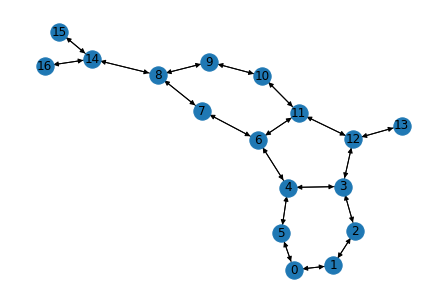

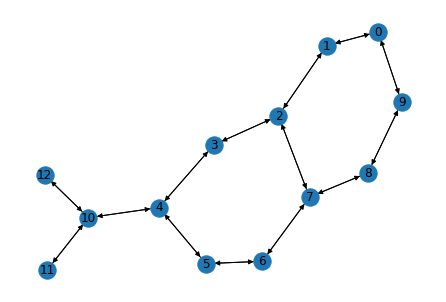

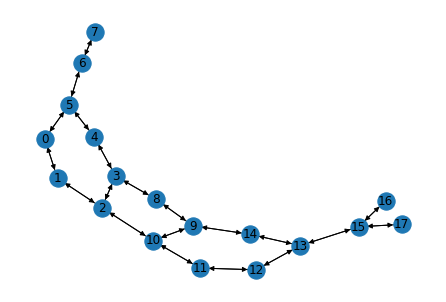

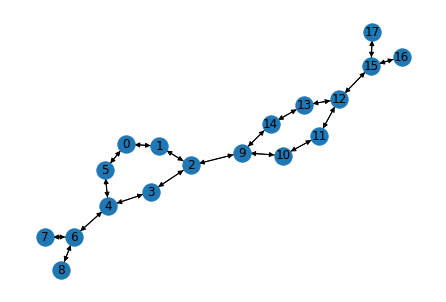

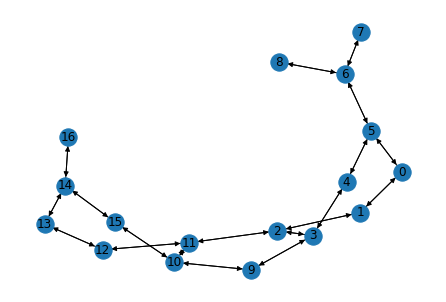

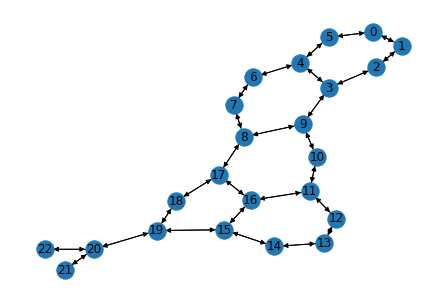

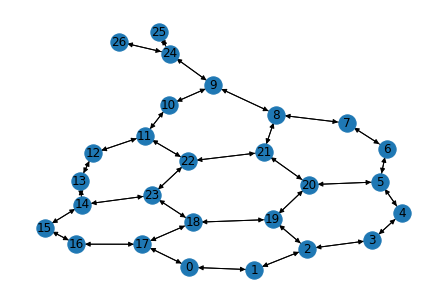

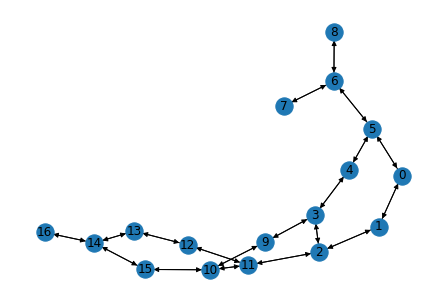

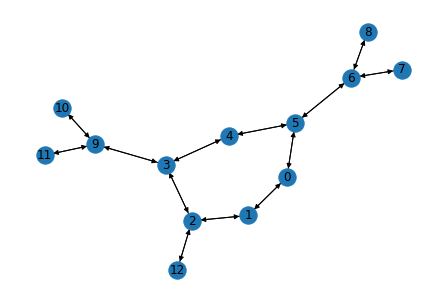

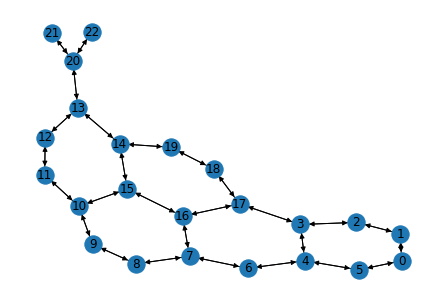

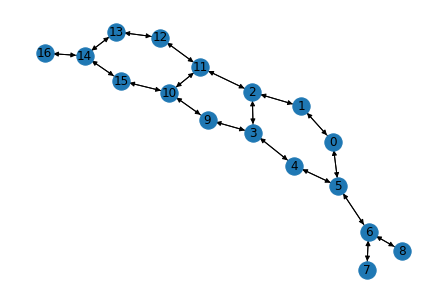

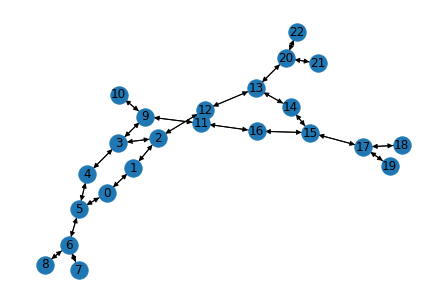

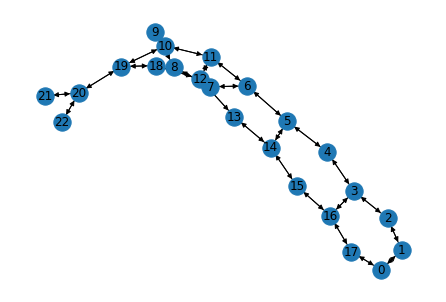

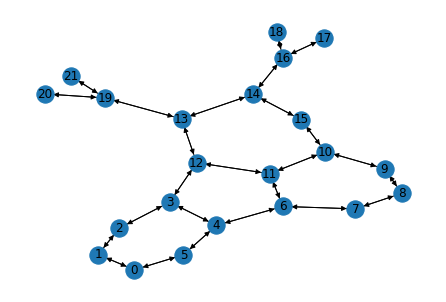

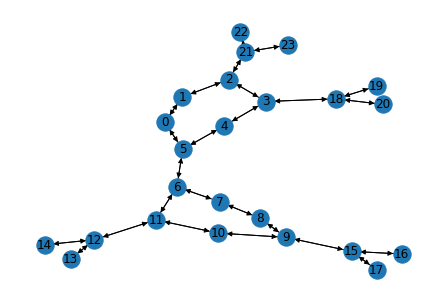

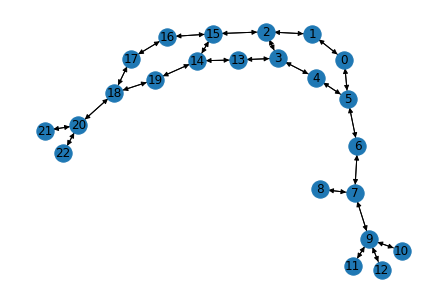

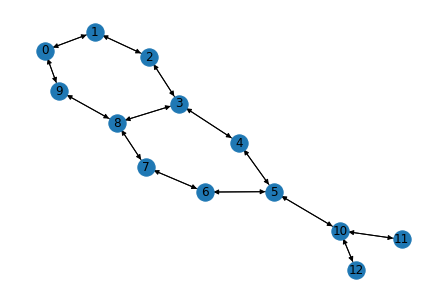

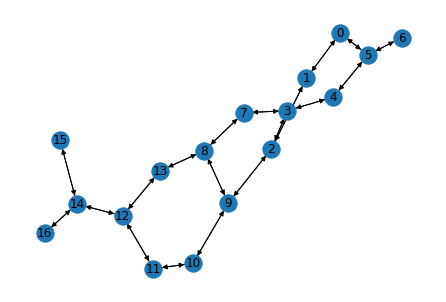

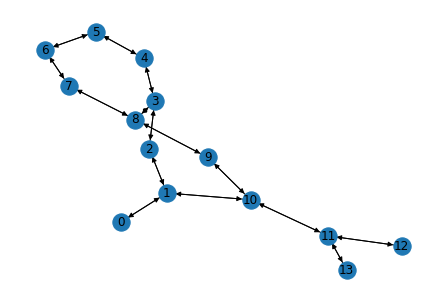

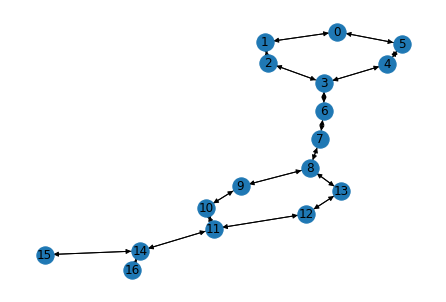

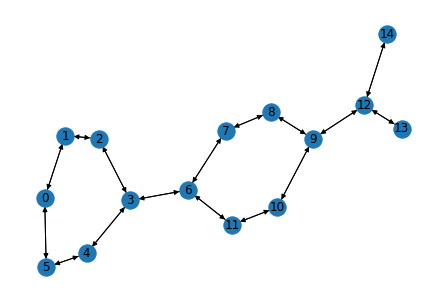

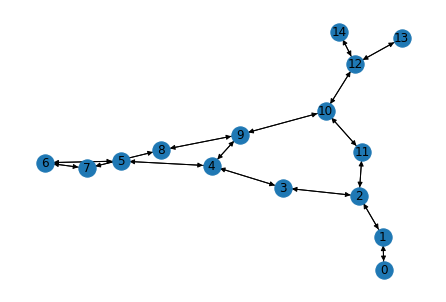

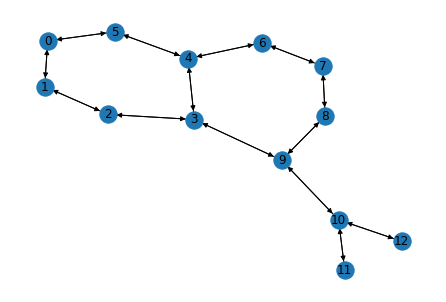

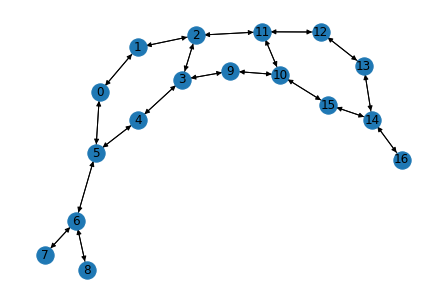

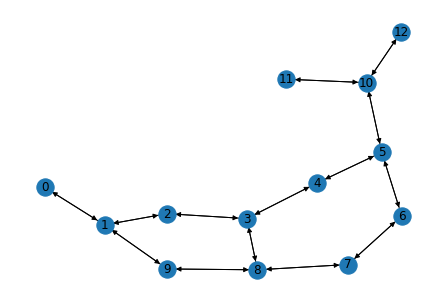

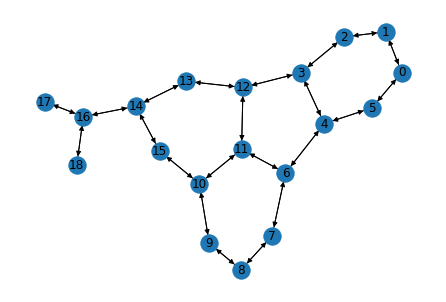

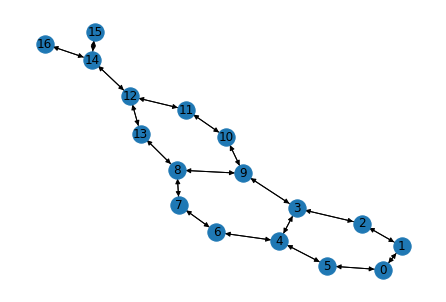

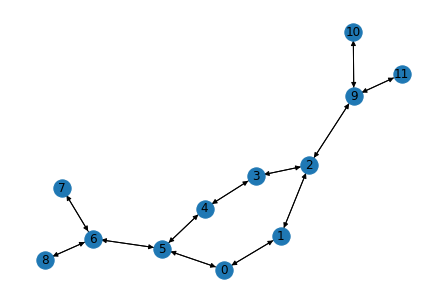

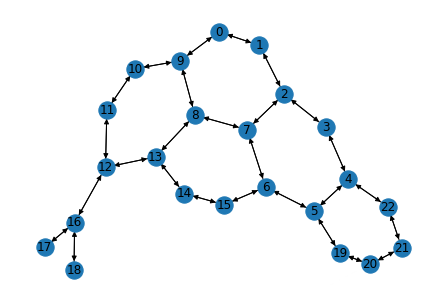

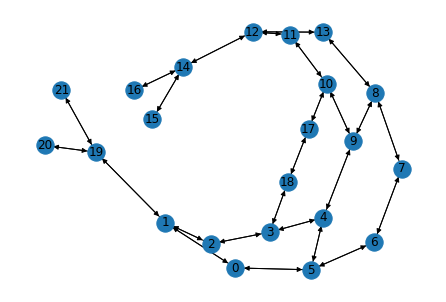

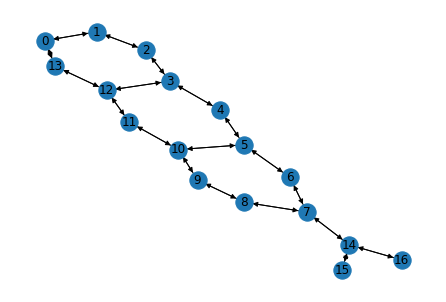

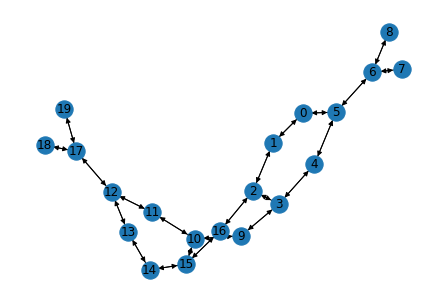

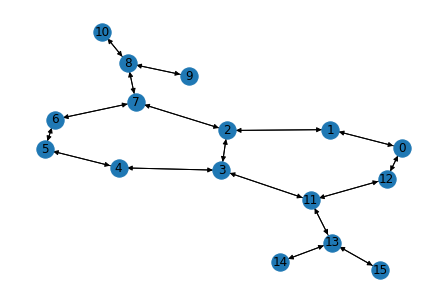

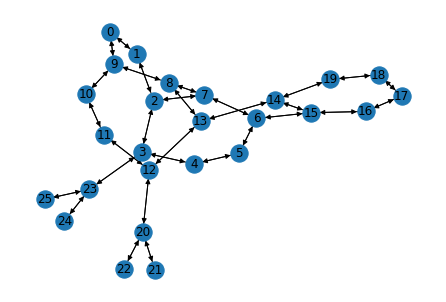

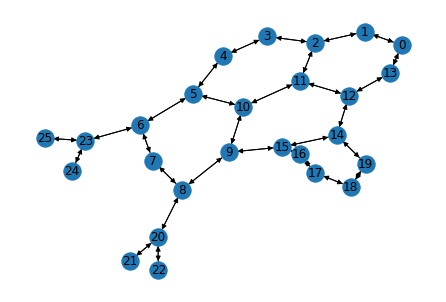

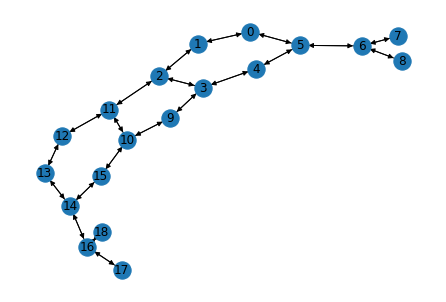

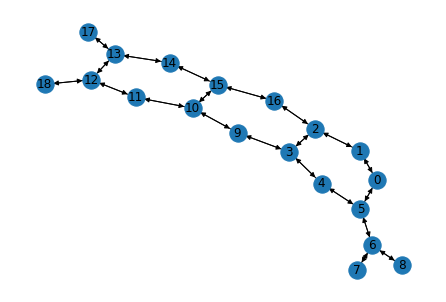

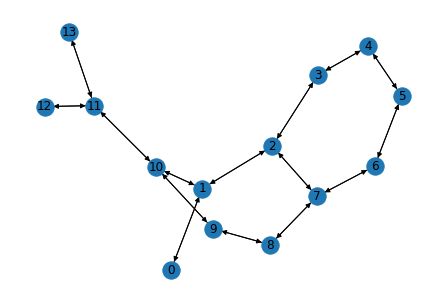

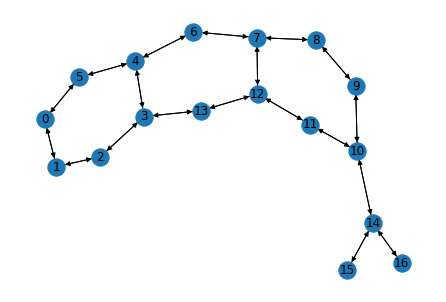

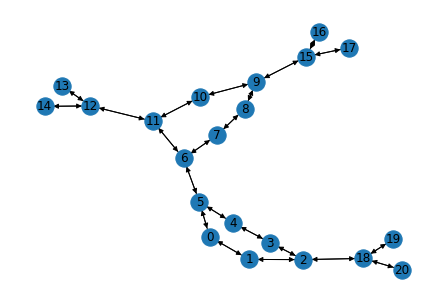

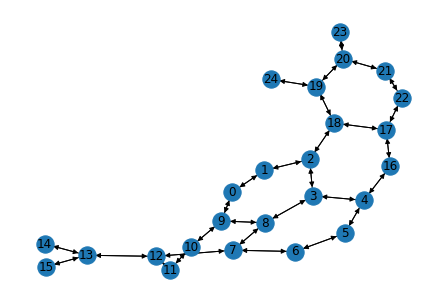

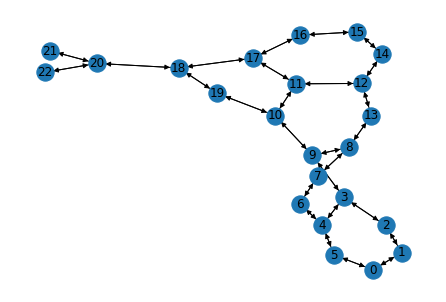

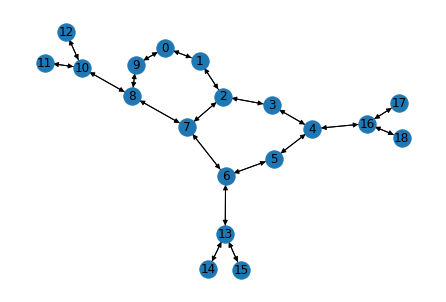

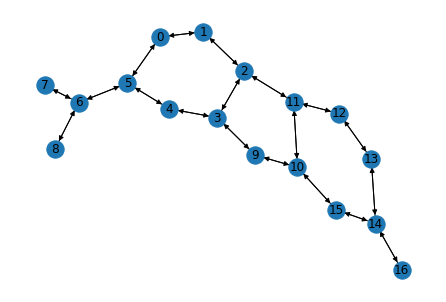

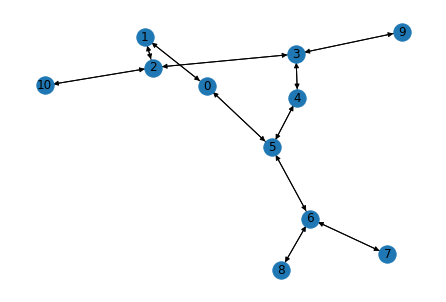

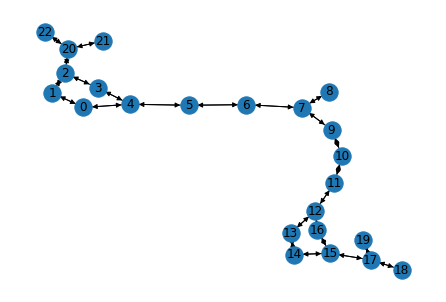

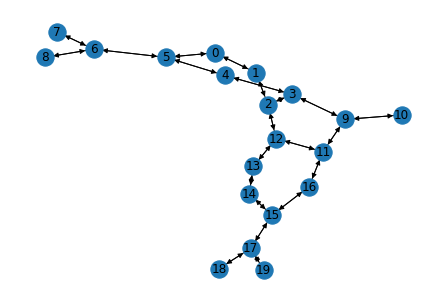

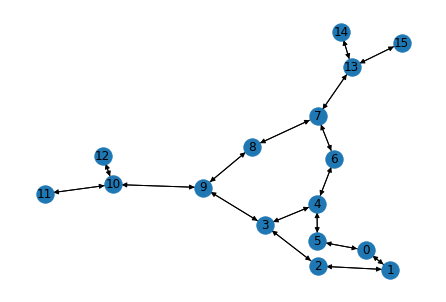

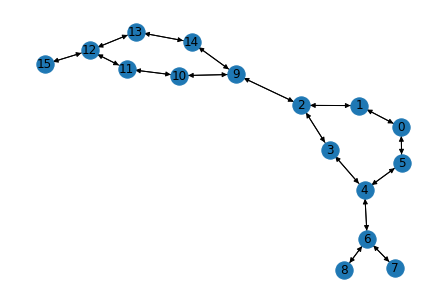

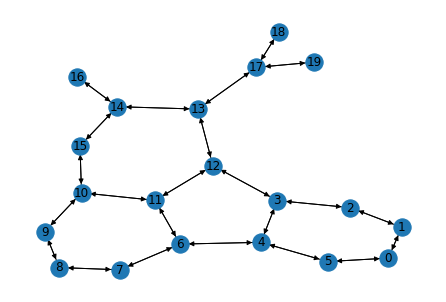

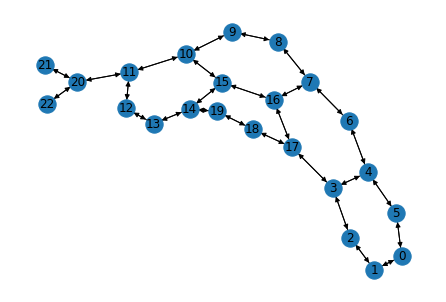

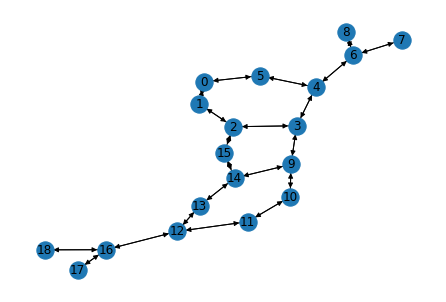

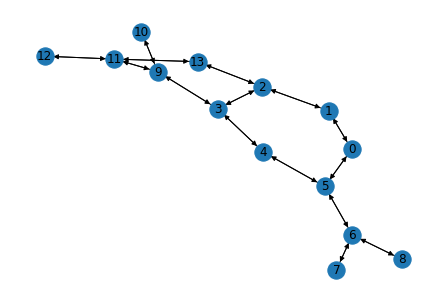

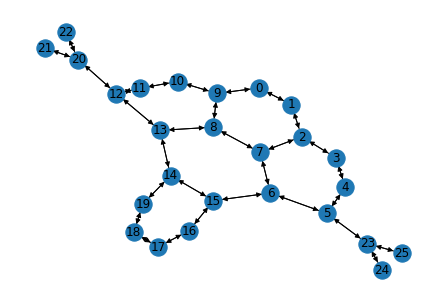

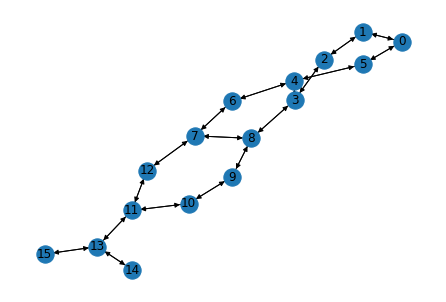

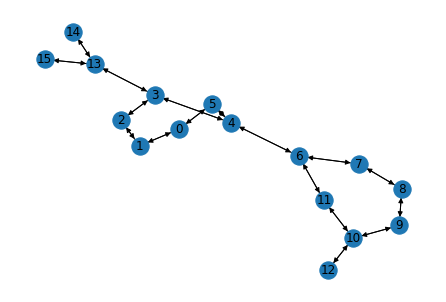

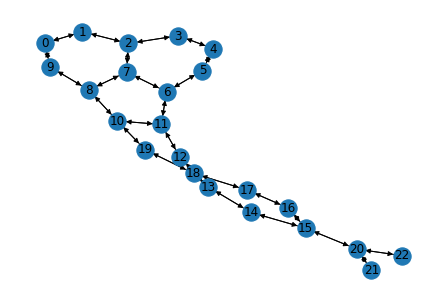

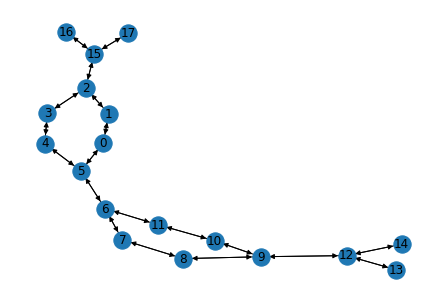

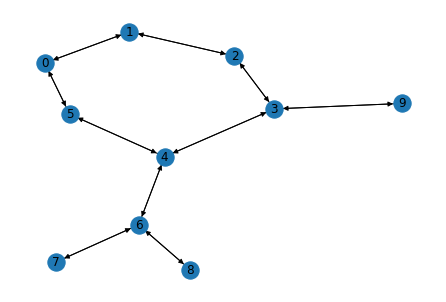

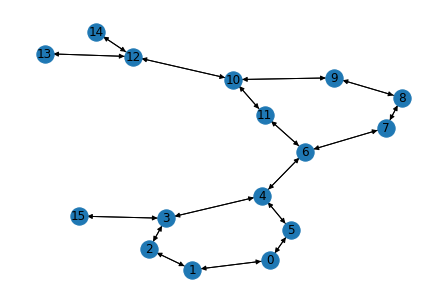

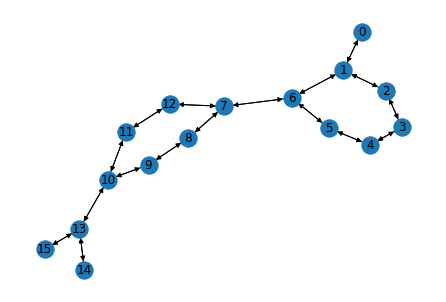

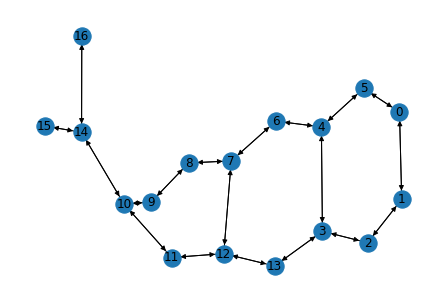

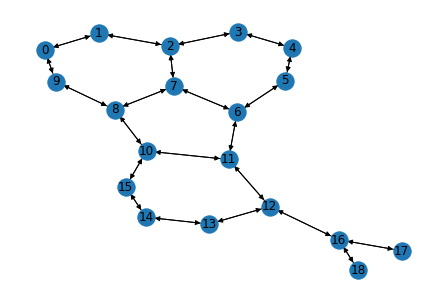

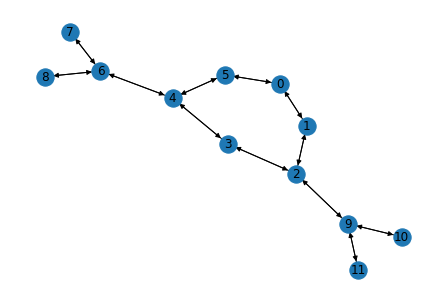

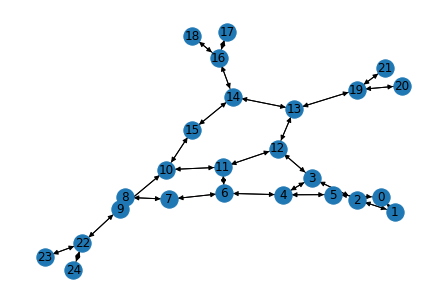

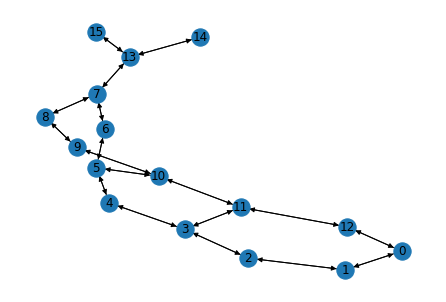

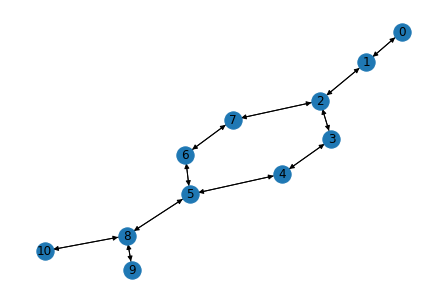

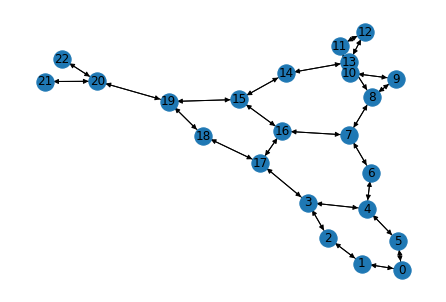

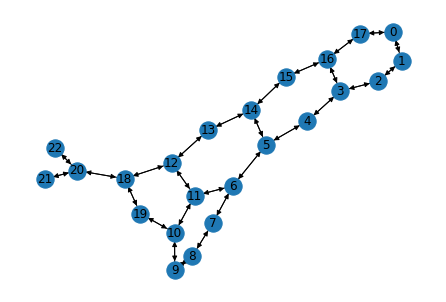

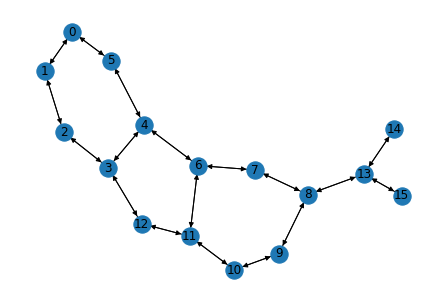

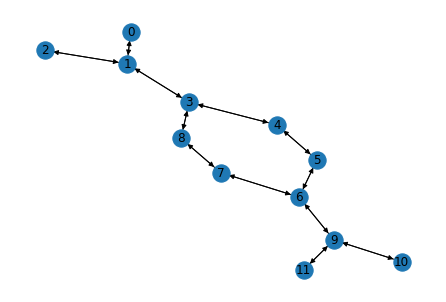

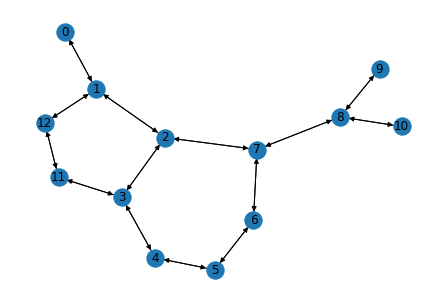

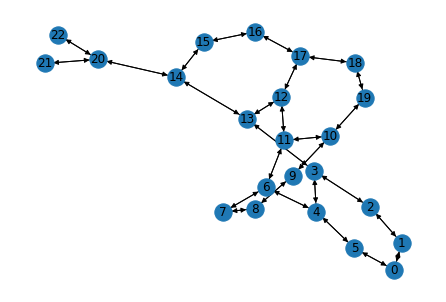

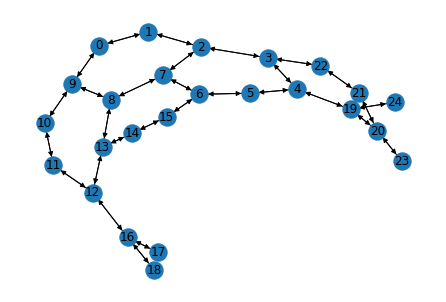

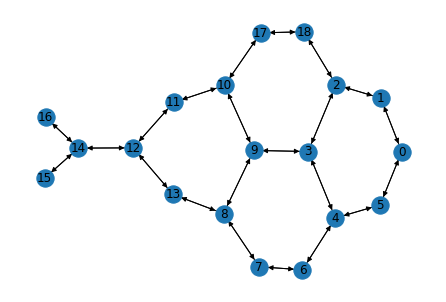

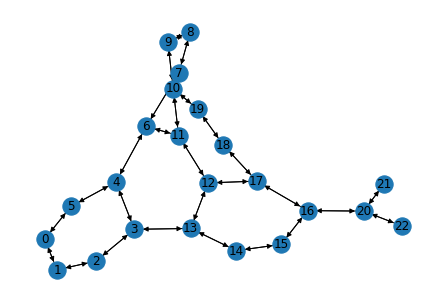

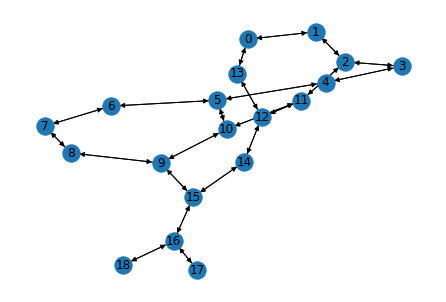

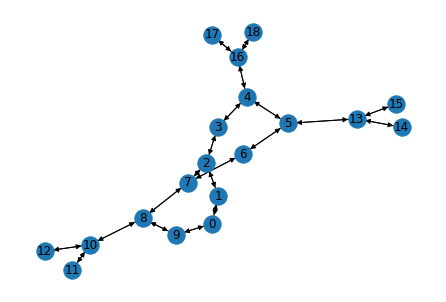

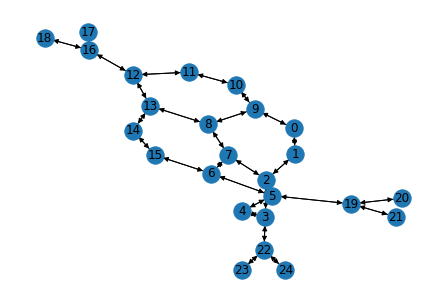

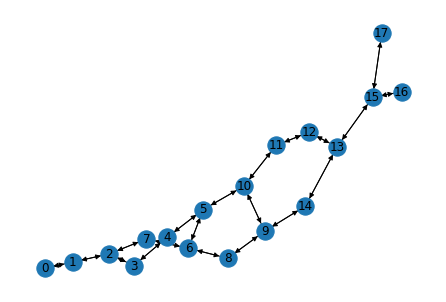

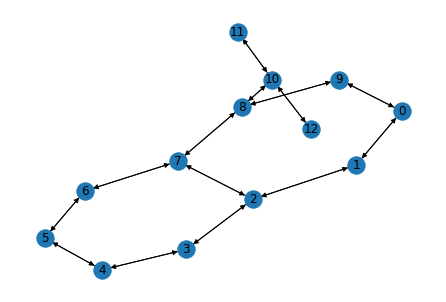

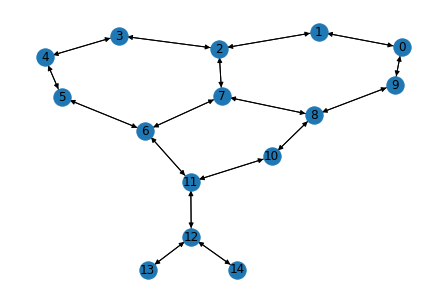

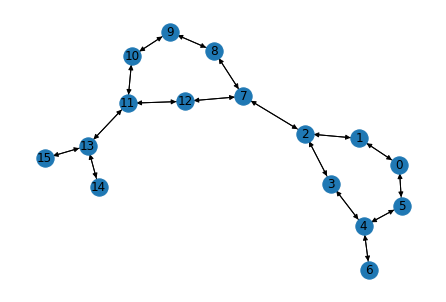

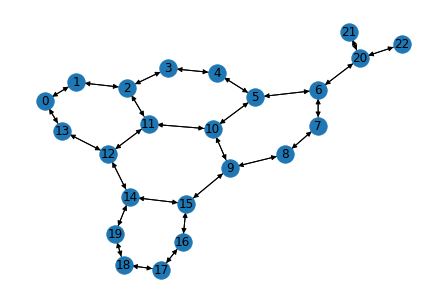

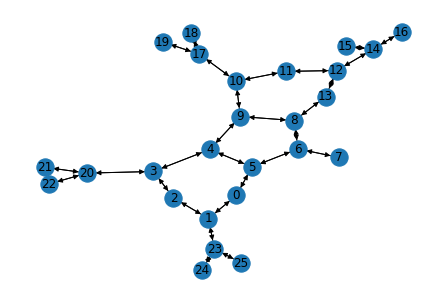

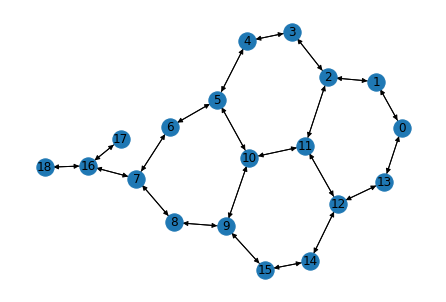

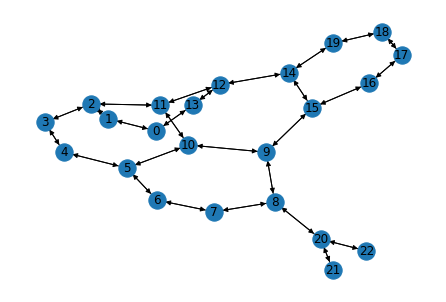

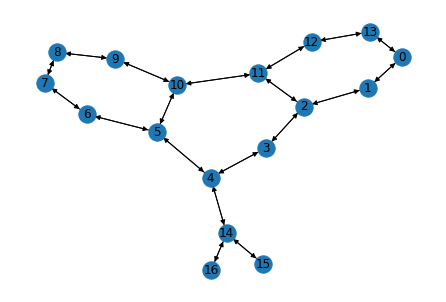

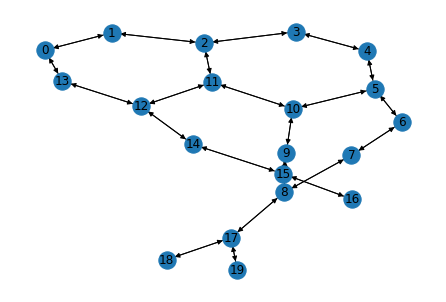

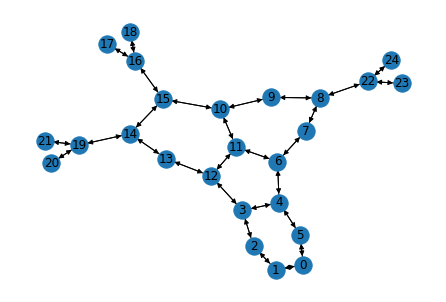

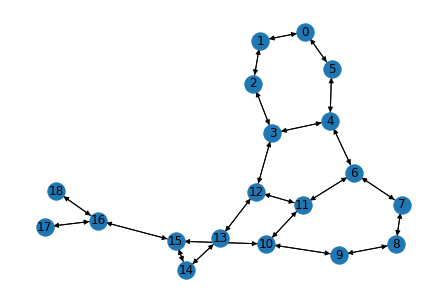

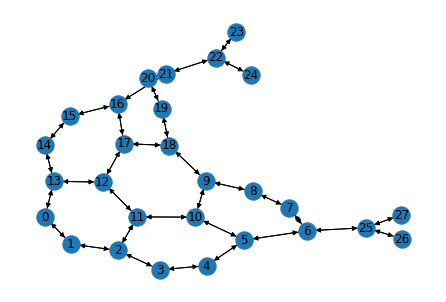

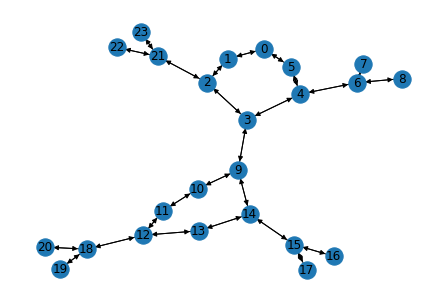

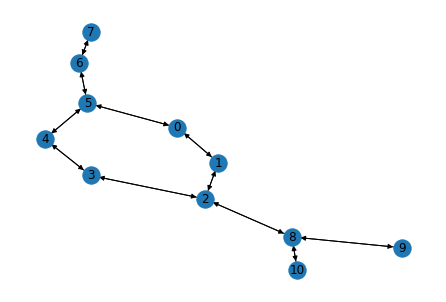

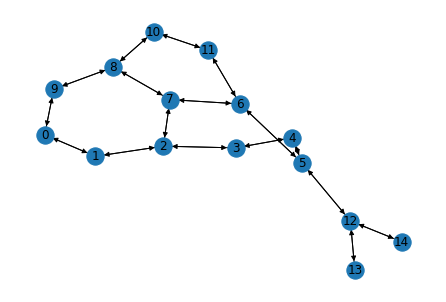

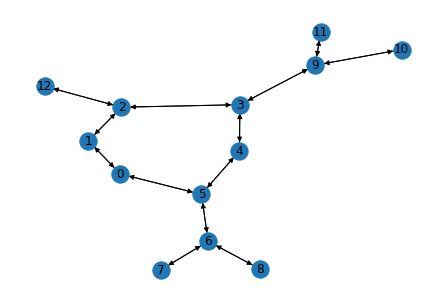

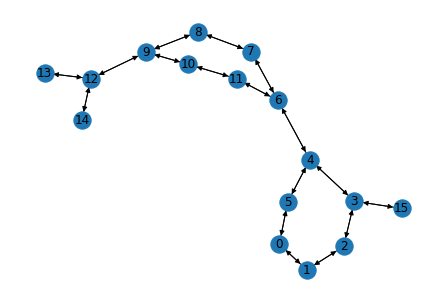

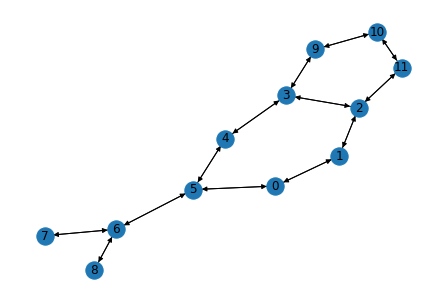

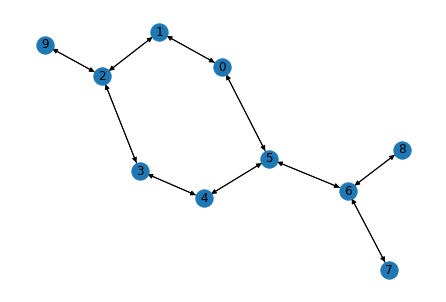

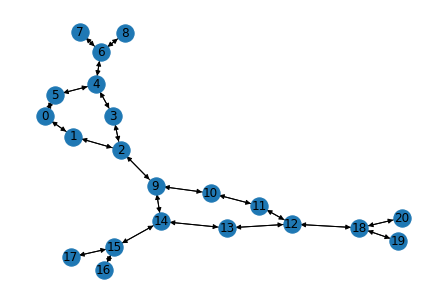

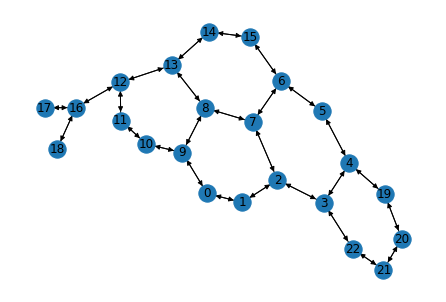

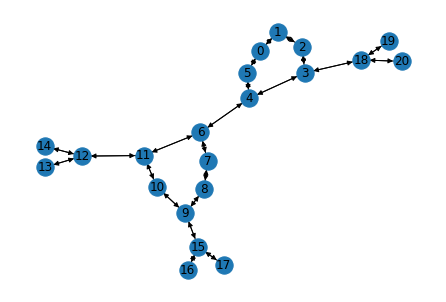

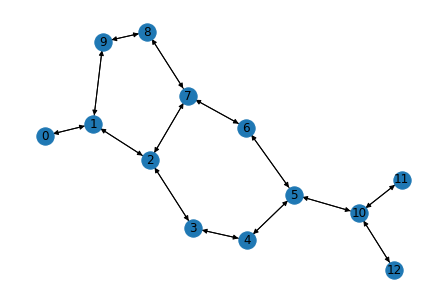

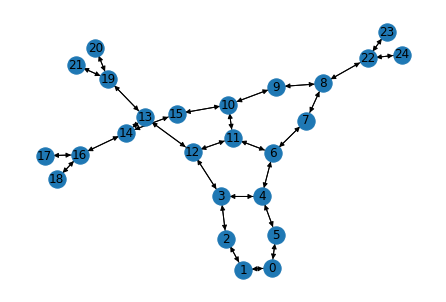

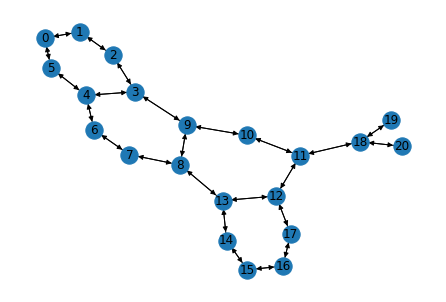

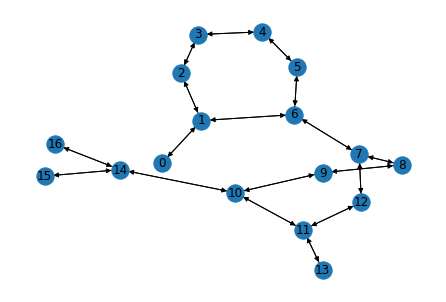

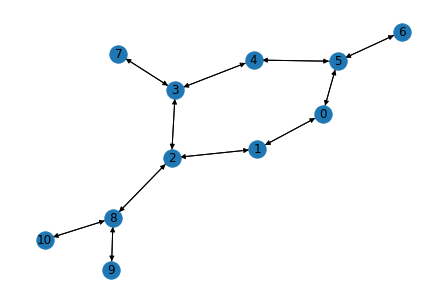

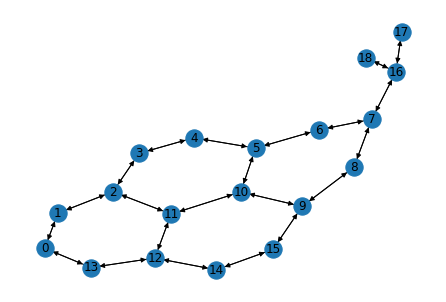

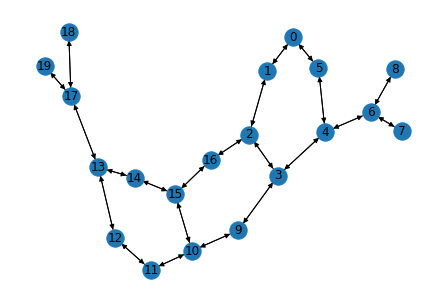

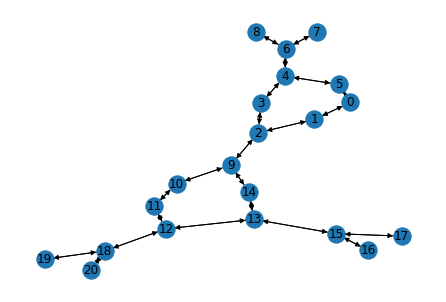

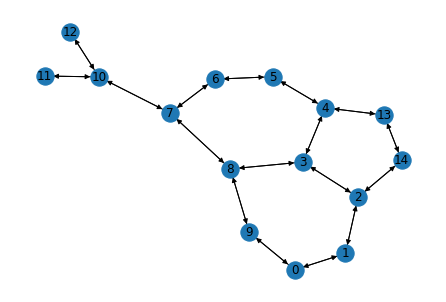

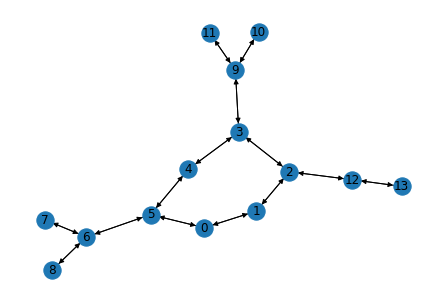

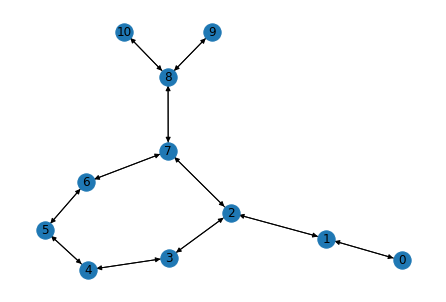

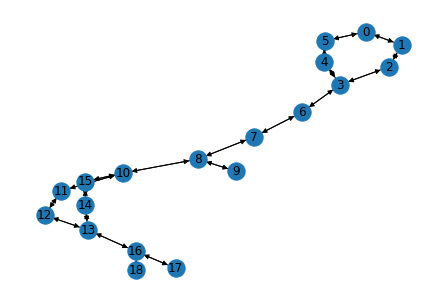

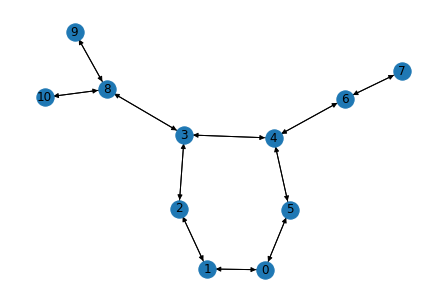

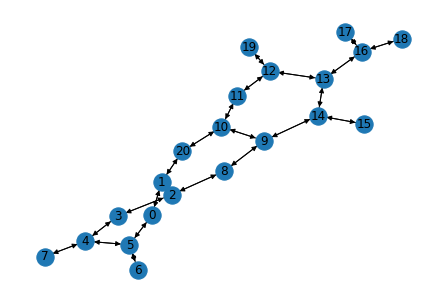

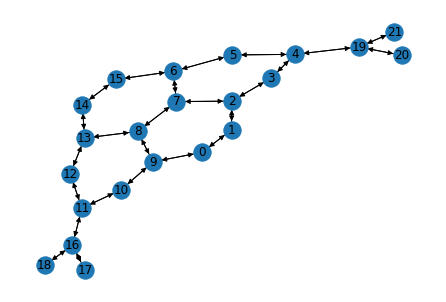

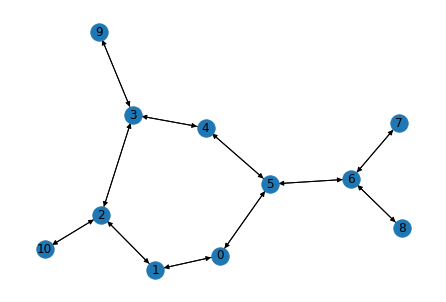

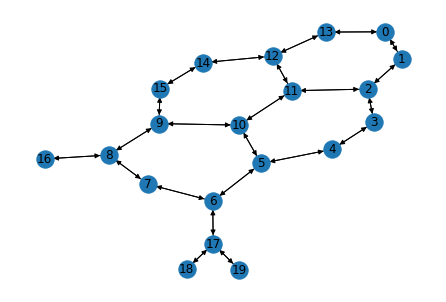

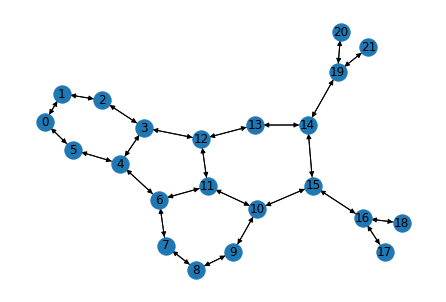

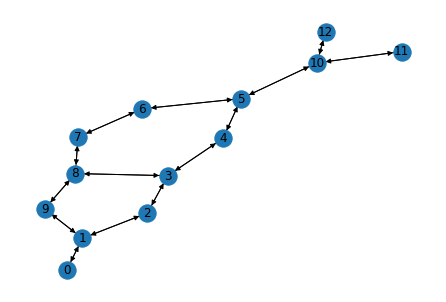

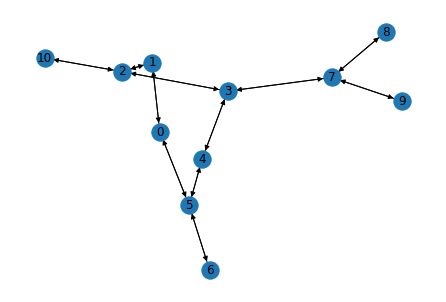

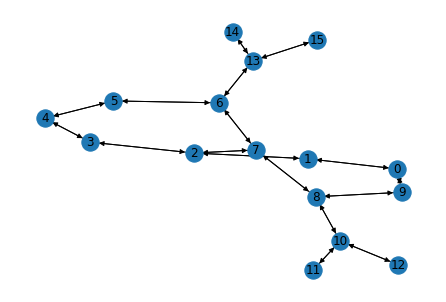

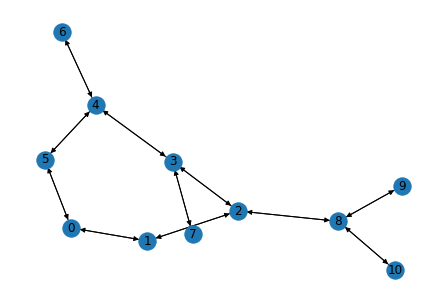

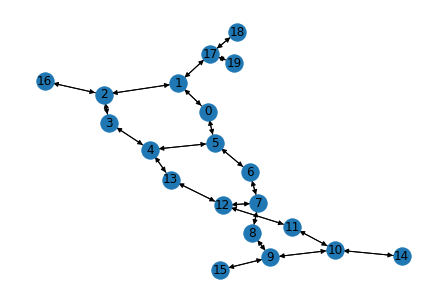

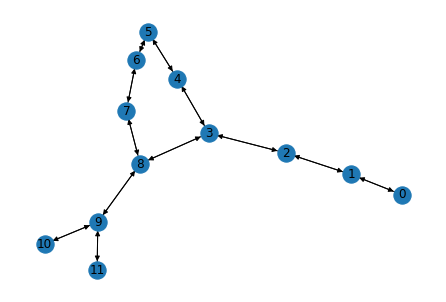

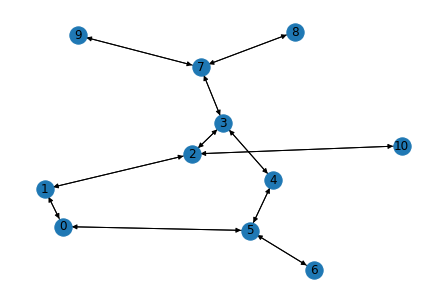

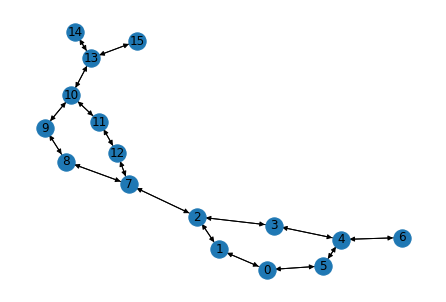

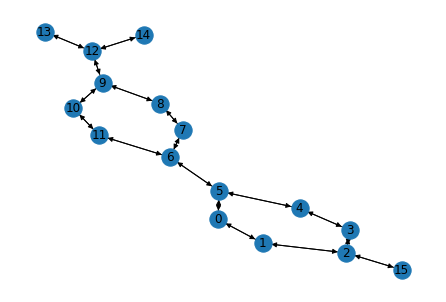

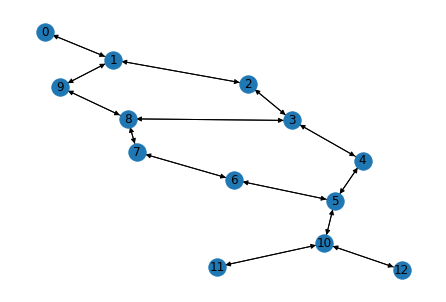

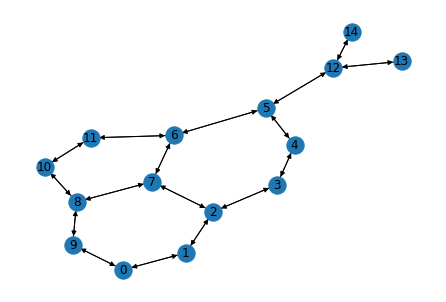

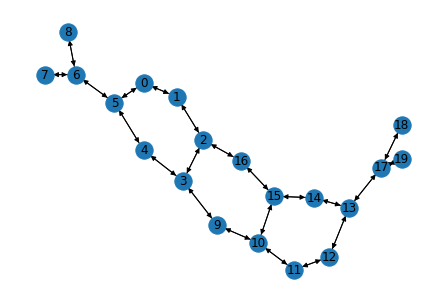

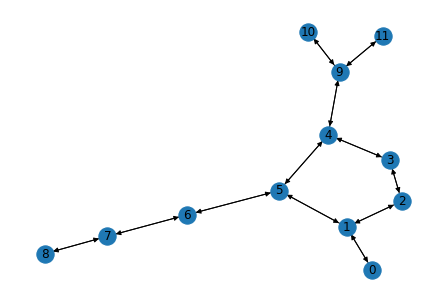

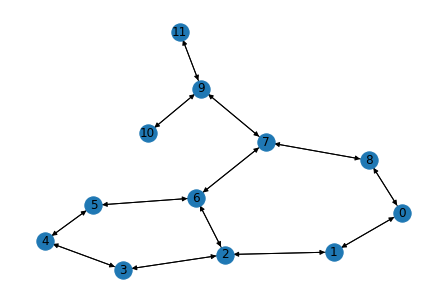

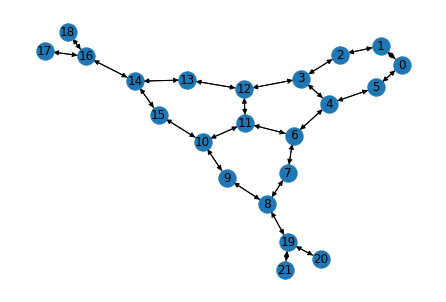

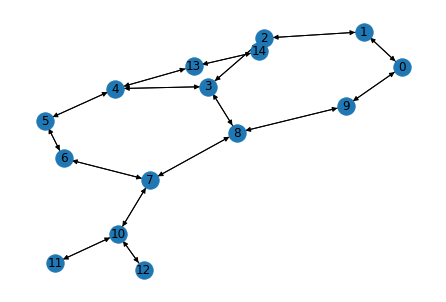

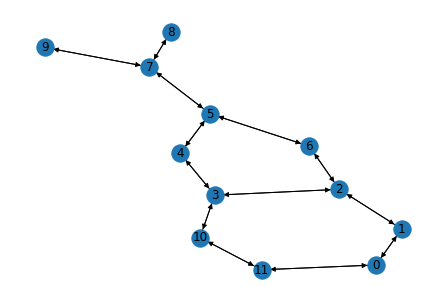

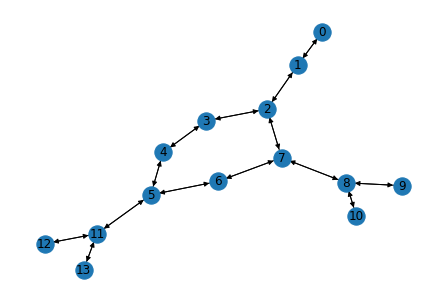

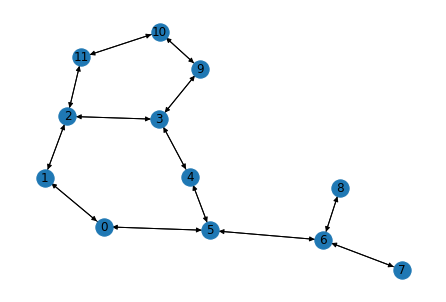

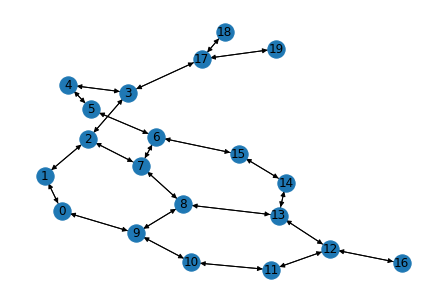

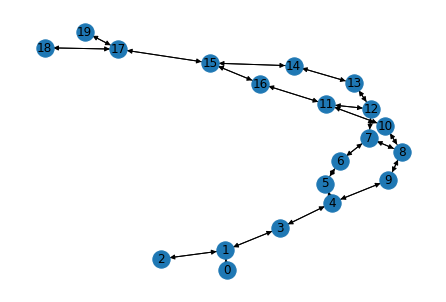

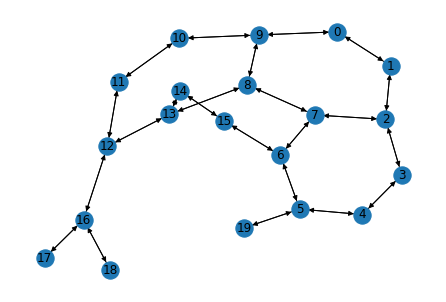

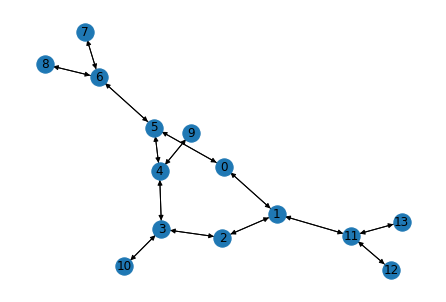

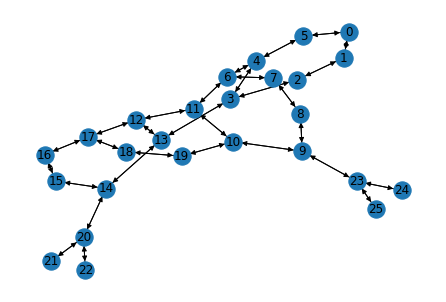

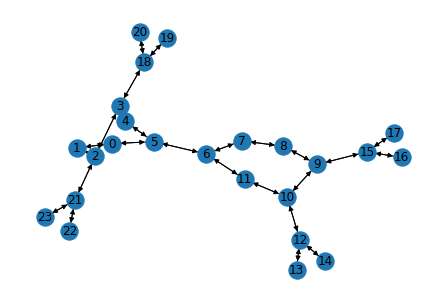

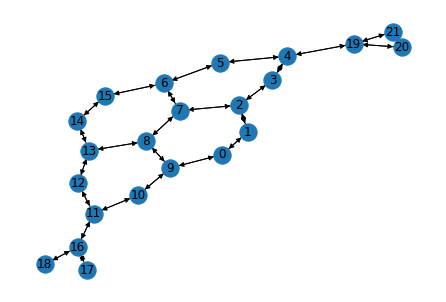

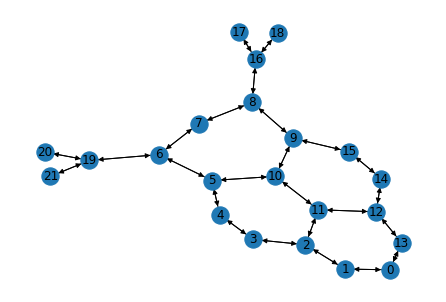

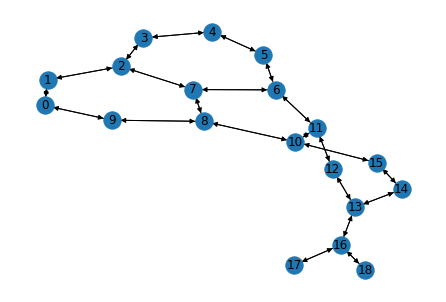

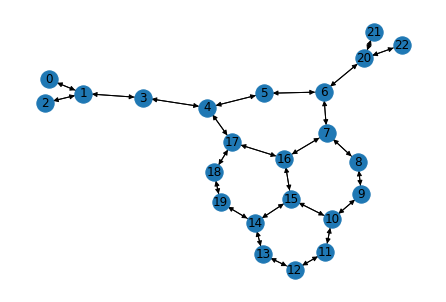

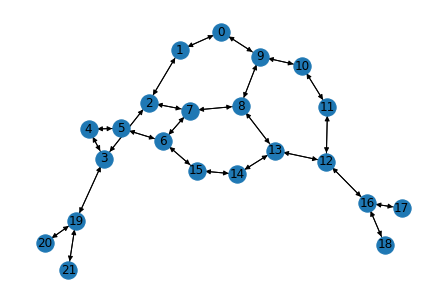

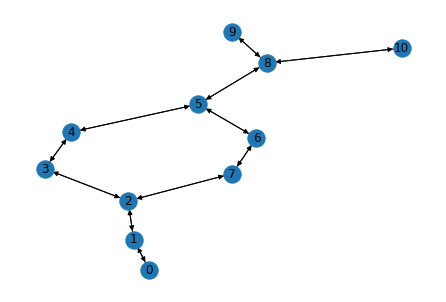

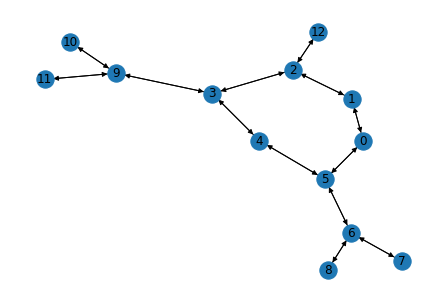

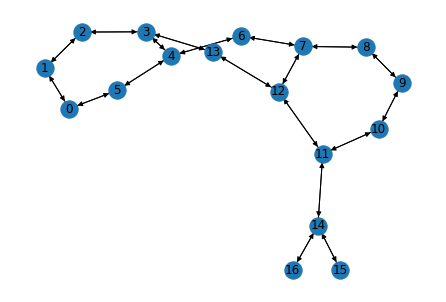

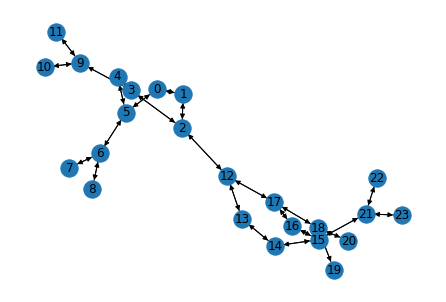

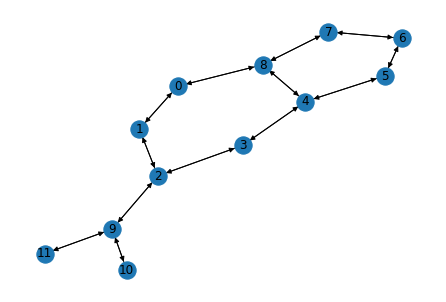

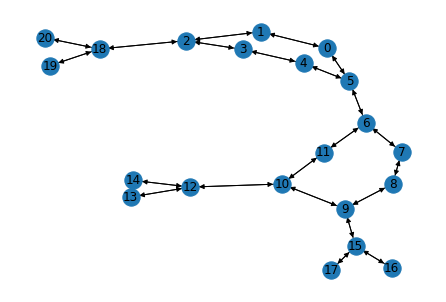

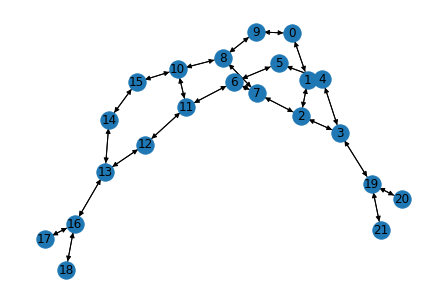

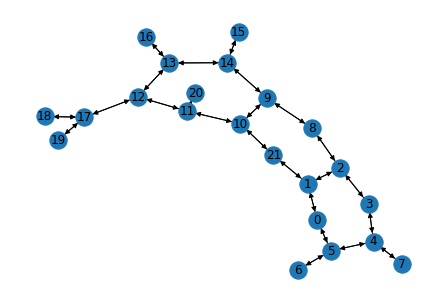

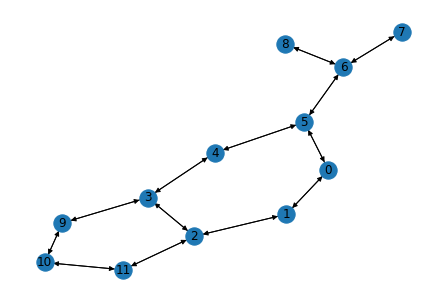

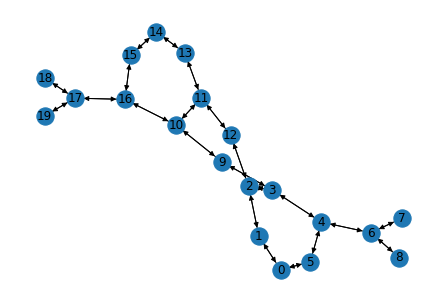

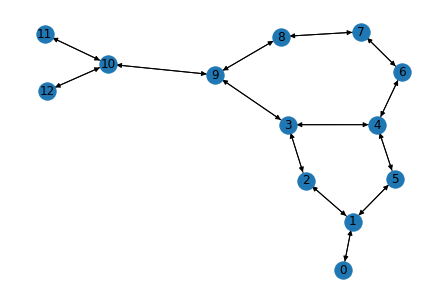

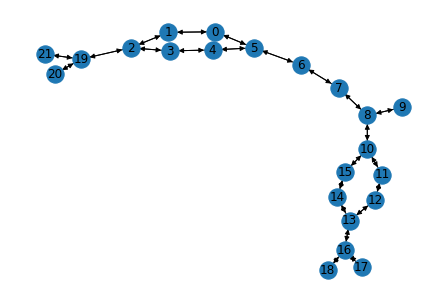

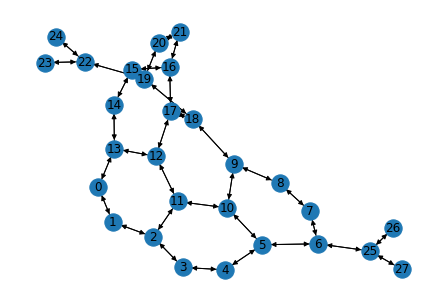

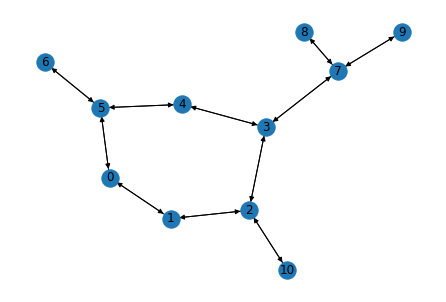

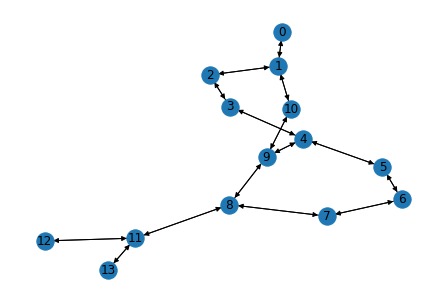

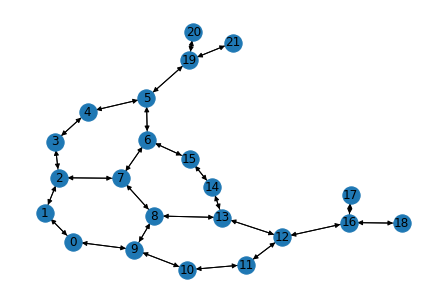

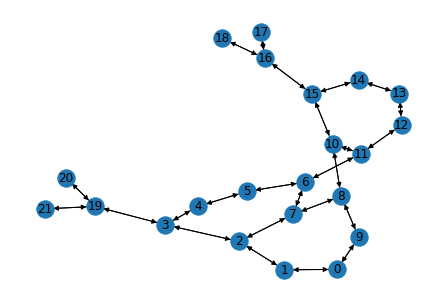

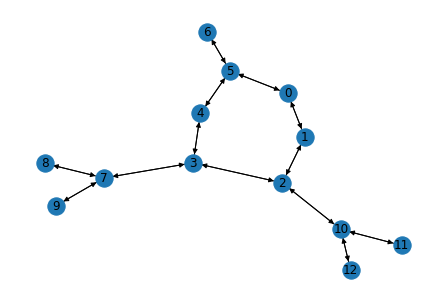

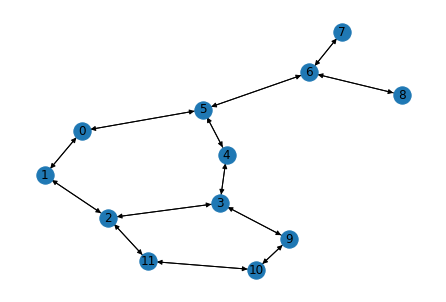

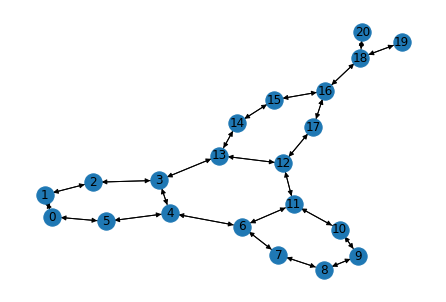

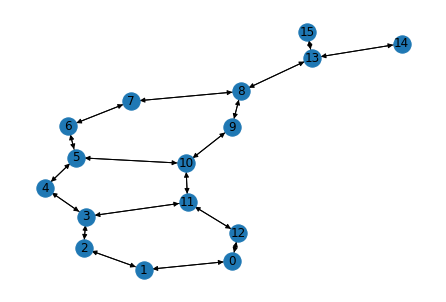

In [57]:
for dglgraph in data_graph['graph']:
    nx.draw(dglgraph.to_networkx(), with_labels=True)
    plt.show()